In [6]:
from __future__ import unicode_literals, print_function
import ast 
import plac
import random
from pathlib import Path
import spacy
from spacy.util import minibatch, compounding
import time
import random
from tqdm import tqdm_notebook as tqdm
import pandas as pd

In [ ]:
# read data in
path = "subset_reviews_er.csv"
train_df = pd.read_csv(path)

In [43]:
train_df['entities_clean']=[ast.literal_eval(i) for i in train_df['entities_clean']]

In [46]:
def create_train_data(df):
  train_data = []
  newnlp = spacy.load("en_core_web_sm")

  for i in tqdm(range(1000)):
    doc = newnlp(df['text'].iloc[i])
    entity_list = df['entities_clean'][i]
    for ent in doc.ents:
      entity_list.append((ent.start_char, ent.end_char, ent.label_))
    entity_dict = {"entities": entity_list}
    train_data.append((df['text'][i], entity_dict))
  return train_data

def create_test_data(df):
  test_data = []
  newnlp = spacy.load("en_core_web_sm")

  for i in tqdm(range(200)):
    doc = newnlp(df['text'].iloc[2000+i])
    entity_list = df['entities_clean'][2000+i]
    for ent in doc.ents:
      entity_list.append((ent.start_char, ent.end_char, ent.label_))
    entity_dict = {"entities": entity_list}
    test_data.append((df['text'][2000+i], entity_dict))
  return test_data

# new entity label
LABEL = "PRODUCT"

TRAIN_DATA = create_train_data(train_df)
TEST_DATA = create_test_data(train_df)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [47]:
# USE SPACY == 2.1.9, 2.2.2 raises duplicate error. need to fix there. 

def main(model='en_core_web_sm', new_model_name="product", output_dir=None, n_iter=15):
    """Set up the pipeline and entity recognizer, and train the new entity."""
    random.seed(0)
    if model is not None: 
        nlp = spacy.load(model)  # load existing spaCy model
        print("Loaded model '%s'" % model)
    else:
        nlp = spacy.blank("en")  # create blank Language class
        print("Created blank 'en' model")
    # Add entity recognizer to model if it's not in the pipeline
    if "ner" not in nlp.pipe_names: #COMMENT: I need to understand this more
        ner = nlp.create_pipe("ner")
        nlp.add_pipe(ner)
    # otherwise, get it, so we can add labels to it
    else:
        ner = nlp.get_pipe("ner")

    ner.add_label(LABEL)  # add new entity label to entity recognizer
    if model is None:
        optimizer = nlp.begin_training()
    else:
        optimizer = nlp.resume_training()
    move_names = list(ner.move_names)
    # get names of other pipes to disable them during training
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe != "ner"]
    with nlp.disable_pipes(*other_pipes):  # only train NER
        sizes = compounding(1.0, 4.0, 1.001)
        # batch the examples using spaCy's minibatch
        start = time.time()
        for itn in tqdm(range(n_iter)):
            random.shuffle(TRAIN_DATA)
            batches = minibatch(TRAIN_DATA, size=sizes)
            losses = {}
            for batch in batches:
                texts, annotations = zip(*batch)
#                 print(texts)
#                 print(annotations)
                nlp.update(texts, annotations, sgd=optimizer, drop=0.35, losses=losses)            
            #print("Training Recall:",nlp.evaluate(random.sample(TRAIN_DATA,200)).ents_r)
            print("Test Recall:",nlp.evaluate(TEST_DATA).ents_p)
            #print("Training Losses", losses)
        end = time.time()
    print("Total training time:",end-start)

    # test the trained model
    for i in range(10):
      test_text = train_df['text'][2000+i] #COMMENT: hard coded might not be generalizable here
      doc = nlp(test_text)
      print("Entities in '%s'" % test_text)
      for ent in doc.ents:
          print(ent.label_, ent.text)

    # save model to output directory
    if output_dir is not None:
        output_dir = Path(output_dir)
        if not output_dir.exists():
            output_dir.mkdir()
        nlp.meta["name"] = new_model_name  # rename model
        nlp.to_disk(output_dir)
        print("Saved model to", output_dir)

        # COMMENT: Abstract this test out to another function? 
        # test the saved model
        print("Loading from", output_dir)
        nlp2 = spacy.load(output_dir)
        # Check the classes have loaded back consistently
        assert nlp2.get_pipe("ner").move_names == move_names
        doc2 = nlp2(test_text)
        for ent in doc2.ents:
            print(ent.label_, ent.text)
    return nlp

model = main()

Loaded model 'en_core_web_sm'


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Test Recall: 86.02352941176471
Test Recall: 88.07382867960246
Test Recall: 88.00915331807781
Test Recall: 87.06035605731654
Test Recall: 87.62071992976294
Test Recall: 87.56567425569177
Test Recall: 87.1839581517001
Test Recall: 86.42765685019207
Test Recall: 87.83666377063423
Test Recall: 86.22881355932203
Test Recall: 86.77544010304852
Test Recall: 87.25532840365376
Test Recall: 87.0169344333478
Test Recall: 86.44642100804744
Test Recall: 86.18197278911565

Total training time: 699.3103680610657
Entities in 'Let me summarize this in 1 word = clean.

This place is probably the shiniest eat all you can that serves around the valley and I have been to alot of them. Too many in fact. Here's some of their best foods.

1. Sushi ( huge selection ) try the scottsdale sushi
2. Mongolian beef ( just the right flavor )
3. Sesame balls!!! (Nuff said)
4. Dessert ( try their mango ice cream)
5. Noodles not the pre cook.'
CARDINAL 1
PRODUCT place
CARDINAL 1
PRODUCT Sushi
PRODUCT scottsdale
PRODUCT 

In [50]:
output_dir

PosixPath('models')

In [49]:
output_dir = "models"
output_dir = Path(output_dir)
if not output_dir.exists():
    output_dir.mkdir()
model.meta["name"] = "ner_subset"  # rename model
model.to_disk(output_dir)
print("Saved model to", output_dir)

# COMMENT: Abstract this test out to another function? 
# test the saved model
print("Loading from", output_dir)
model2 = spacy.load(output_dir)
# Check the classes have loaded back consistently
assert model2.get_pipe("ner").move_names == move_names
doc2 = model2(test_text)
for ent in doc2.ents:
    print(ent.label_, ent.text)

Saved model to models
Loading from models


NameError: name 'move_names' is not defined

x = "Ordered combo 3.  It comes with two plates or rice (or bread), one skewer of chicken breast kebob, one skewer of koobideh, one skewer of barg kebob, 3 grilled tomatoes, a plate of parsley and sliced radish, a bunch of basil.  No salad.\n\nThe meat were all very flavourful, not dry and juicy!!! The taste was very good.   Definitely a lot of food for two people. :)\n\nThe waitress was very friendly and attentive.  \n\nI read another review that they do not accept amex, and yeah they really don't.  But I asked before I paid for the meal so it's ok."

In [62]:
x[14:15]

'3'

In [10]:
model

## HELLO

In [1]:
from __future__ import unicode_literals, print_function
import ast 
import plac
import random
from pathlib import Path
import spacy
from spacy.util import minibatch, compounding
import time
import random
import pandas as pd

In [12]:
from tqdm import tqdm_notebook as tqdm

In [32]:
path = "spacy_train_clean.csv"
train_df = pd.read_csv(path)

In [37]:
# clean format of entity tuples
train_df['entities_clean']=[ast.literal_eval(tup) for tup in tqdm(train_df['entities'])]

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [38]:
train_df_real = train_df.copy()

In [39]:
train_df.head()

,review_id,text,entities,entities_clean
0,yi0R0Ugj_xUx_Nek0-_Qig,Went in for a lunch. Steak sandwich was delici...,"[(66, 71, 'PRODUCT'), (219, 224, 'PRODUCT'), (...","[(66, 71, PRODUCT), (219, 224, PRODUCT), (27, ..."
1,fdiNeiN_hoCxCMy2wTRW9g,I'll be the first to admit that I was not exci...,"[(1145, 1152, 'PRODUCT'), (1216, 1223, 'PRODUC...","[(1145, 1152, PRODUCT), (1216, 1223, PRODUCT),..."
2,G7XHMxG0bx9oBJNECG4IFg,Tracy dessert had a big name in Hong Kong and ...,"[(900, 907, 'PRODUCT'), (922, 925, 'PRODUCT'),...","[(900, 907, PRODUCT), (922, 925, PRODUCT), (87..."
3,8e9HxxLjjqc9ez5ezzN7iQ,This place has gone down hill. Clearly they h...,"[(130, 134, 'PRODUCT'), (238, 243, 'PRODUCT'),...","[(130, 134, PRODUCT), (238, 243, PRODUCT), (21..."
4,kbtscdyz6lvrtGjD1quQTg,"Like walking back in time, every Saturday morn...","[(422, 427, 'PRODUCT'), (349, 352, 'PRODUCT'),...","[(422, 427, PRODUCT), (349, 352, PRODUCT), (31..."


In [40]:
train_df.entities_clean[0]

[(66, 71, 'PRODUCT'),
 (219, 224, 'PRODUCT'),
 (27, 35, 'PRODUCT'),
 (59, 71, 'PRODUCT'),
 (21, 26, 'PRODUCT'),
 (256, 262, 'PRODUCT'),
 (14, 19, 'PRODUCT')]

In [19]:
def create_train_data(df):
  train_data = []
  newnlp = spacy.load("en_core_web_sm")

  for i in range(1000):
    doc = newnlp(df['text'].iloc[i])
    entity_list = df['entities_clean'][i]
    for ent in doc.ents:
      entity_list.append((ent.start_char, ent.end_char, ent.label_))
    entity_dict = {"entities": entity_list}
    train_data.append((df['text'][i], entity_dict))
  return train_data

In [20]:
def create_test_data(df):
  test_data = []
  newnlp = spacy.load("en_core_web_sm")

  for i in range(200):
    doc = newnlp(df['text'].iloc[2000+i])
    entity_list = df['entities_clean'][2000+i]
    for ent in doc.ents:
      entity_list.append((ent.start_char, ent.end_char, ent.label_))
    entity_dict = {"entities": entity_list}
    test_data.append((df['text'][2000+i], entity_dict))
  return test_data

In [24]:
train_df.head()

,review_id,text,entities,entities_clean
0,yi0R0Ugj_xUx_Nek0-_Qig,Went in for a lunch. Steak sandwich was delici...,"[(66, 71, 'PRODUCT'), (219, 224, 'PRODUCT'), (...","[(66, 71, PRODUCT), (219, 224, PRODUCT), (27, ..."
1,fdiNeiN_hoCxCMy2wTRW9g,I'll be the first to admit that I was not exci...,"[(1145, 1152, 'PRODUCT'), (1216, 1223, 'PRODUC...","[(1145, 1152, PRODUCT), (1216, 1223, PRODUCT),..."
2,G7XHMxG0bx9oBJNECG4IFg,Tracy dessert had a big name in Hong Kong and ...,"[(900, 907, 'PRODUCT'), (922, 925, 'PRODUCT'),...","[(900, 907, PRODUCT), (922, 925, PRODUCT), (87..."
3,8e9HxxLjjqc9ez5ezzN7iQ,This place has gone down hill. Clearly they h...,"[(130, 134, 'PRODUCT'), (238, 243, 'PRODUCT'),...","[(130, 134, PRODUCT), (238, 243, PRODUCT), (21..."
4,kbtscdyz6lvrtGjD1quQTg,"Like walking back in time, every Saturday morn...","[(422, 427, 'PRODUCT'), (349, 352, 'PRODUCT'),...","[(422, 427, PRODUCT), (349, 352, PRODUCT), (31..."


In [26]:
print("Loading model...")
model='en_core_web_sm' 
new_model_name="product"
output_dir=None
n_iter=15
if model is not None: 
    nlp = spacy.load(model)  # load existing spaCy model
    print("Loaded model '%s'" % model)
else:
    nlp = spacy.blank("en")  # create blank Language class
    print("Created blank 'en' model")

print("Configuring Pipeline...")
# Add entity recognizer to model if it's not in the pipeline
# otherwise, get it, so we can add labels to it
if "ner" not in nlp.pipe_names: 
    ner = nlp.create_pipe("ner")
    nlp.add_pipe(ner)
else:
    ner = nlp.get_pipe("ner")

if model is None:
    optimizer = nlp.begin_training()
else:
    optimizer = nlp.resume_training()

ner.add_label(LABEL)  # add new entity label to entity recognizer

move_names = list(ner.move_names)

# get names of other pipes to disable them during training
other_pipes = [pipe for pipe in nlp.pipe_names if pipe != "ner"]

Loading model...
Loaded model 'en_core_web_sm'
Configuring Pipeline...


In [28]:
TRAIN_DATA

[("So I chose this place because they were open at the time I wanted to go pick up dinner at 4pm.  Ordered a Papaya salad and Pad Thai. They asked how I wanted it Mild Medium or Hot.  I stayed safe and said mild for both.  Well, when I got home and opened up the containers--of which they stupidly put them in one bag-dumb because papaya salad is always cold- I had to remove it in the car before heading home.  The Papaya salad was not evenly cut...their shredder is not working and it is supposed to be picked up like speghetti...this was clumps of papaya shredded half way. ALL I COULD TASTE WAS ONION. ONION...like eating a clumpy mouthful of ONION.  Horrid.  The Pad Thai had dry pieces of chicken and ZERO seasoning.  AWFUL. CRAP.  Waste of $17. NEVER BE BACK. They cannot produce Thai food that is worthy.  Instead of driving back to the place to return this...I'm writing this review. STAY AWAY.  Should have gone to Thai Plates or tried another place..these guys were the only ones open at t

In [27]:
with nlp.disable_pipes(*other_pipes):  # only train NER
    sizes = compounding(1.0, 4.0, 1.001)

    # batch the examples using spaCy's minibatch
    start = time.time()
    for itn in tqdm(range(n_iter)):
        random.shuffle(TRAIN_DATA)
        batches = minibatch(TRAIN_DATA, size=sizes)
        losses = {}
        for batch in batches:
            texts, annotations = zip(*batch)
            nlp.update(texts, annotations, sgd=optimizer, drop=0.35, losses=losses)            

        print("Test Recall:",nlp.evaluate(TEST_DATA).ents_p)
        #print("Training Recall:",nlp.evaluate(random.sample(TRAIN_DATA,200)).ents_r)
        #print("Training Losses", losses)

    end = time.time()
    print("Total training time:",end-start)


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


ValueError: [E103] Trying to set conflicting doc.ents: '(106, 112, 'PRODUCT')' and '(106, 112, 'ORG')'. A token can only be part of one entity, so make sure the entities you're setting don't overlap.

In [23]:
# new entity label
LABEL = "PRODUCT"

random.seed(0)

TRAIN_DATA = create_train_data(train_df)
TEST_DATA = create_test_data(train_df)

def main(model='en_core_web_sm', new_model_name="product", output_dir=None, n_iter=15):
    """Set up the pipeline and entity recognizer, and train the new entity."""
    
    print("Loading model...")
    if model is not None: 
        nlp = spacy.load(model)  # load existing spaCy model
        print("Loaded model '%s'" % model)
    else:
        nlp = spacy.blank("en")  # create blank Language class
        print("Created blank 'en' model")
    
    print("Configuring Pipeline...")
    # Add entity recognizer to model if it's not in the pipeline
    # otherwise, get it, so we can add labels to it
    if "ner" not in nlp.pipe_names: 
        ner = nlp.create_pipe("ner")
        nlp.add_pipe(ner)
    else:
        ner = nlp.get_pipe("ner")
    
    if model is None:
        optimizer = nlp.begin_training()
    else:
        optimizer = nlp.resume_training()
        
    ner.add_label(LABEL)  # add new entity label to entity recognizer
        
    move_names = list(ner.move_names)
    
    # get names of other pipes to disable them during training
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe != "ner"]
    
    with nlp.disable_pipes(*other_pipes):  # only train NER
        sizes = compounding(1.0, 4.0, 1.001)
    
        # batch the examples using spaCy's minibatch
        start = time.time()
        for itn in tqdm(range(n_iter)):
            random.shuffle(TRAIN_DATA)
            batches = minibatch(TRAIN_DATA, size=sizes)
            losses = {}
            for batch in batches:
                texts, annotations = zip(*batch)
                nlp.update(texts, annotations, sgd=optimizer, drop=0.35, losses=losses)            
            
            print("Test Recall:",nlp.evaluate(TEST_DATA).ents_p)
            #print("Training Recall:",nlp.evaluate(random.sample(TRAIN_DATA,200)).ents_r)
            #print("Training Losses", losses)
            
        end = time.time()
    print("Total training time:",end-start)

    # test the trained model
    for i in range(10):
      test_text = train_df['text'][2000+i] #COMMENT: hard coded might not be generalizable here
      doc = nlp(test_text)
      print("Entities in '%s'" % test_text)
      for ent in doc.ents:
          print(ent.label_, ent.text)

    # save model to output directory
    if output_dir is not None:
        output_dir = Path(output_dir)
        if not output_dir.exists():
            output_dir.mkdir()
        nlp.meta["name"] = new_model_name  # rename model
        nlp.to_disk(output_dir)
        print("Saved model to", output_dir)

        # COMMENT: Abstract this test out to another function? 
        # test the saved model
        print("Loading from", output_dir)
        nlp2 = spacy.load(output_dir)
        # Check the classes have loaded back consistently
        assert nlp2.get_pipe("ner").move_names == move_names
        doc2 = nlp2(test_text)
        for ent in doc2.ents:
            print(ent.label_, ent.text)
    return nlp

model = main(output_dir="models")

Loaded model 'en_core_web_sm'


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:44: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


ValueError: [E103] Trying to set conflicting doc.ents: '(100, 107, 'CARDINAL')' and '(100, 107, 'CARDINAL')'. A token can only be part of one entity, so make sure the entities you're setting don't overlap.

In [0]:
brand_list = []
# COMMENT: what's n/i? can make clearer here on what's within train_df
for (n,i) in enumerate(train_df['entities_clean'][:100]):
  text = train_df['text'][n]
  for pair in i:
    brand_list.append(text[pair[0]:pair[1]])
    
import numpy as np
unique_brands = np.unique(brand_list)

In [0]:
newbrand_list = []
for (n,i) in enumerate(train_df['entities_clean'][2000:2100]):
  text = train_df['text'][n+2000]
  for pair in i:
    newbrand_list.append(text[pair[0]:pair[1]])
    
import numpy as np
newunique_brands = np.unique(newbrand_list)

In [0]:
import numpy as np

new_brand_list = []
for (n,i) in enumerate(train_df['text'][:100]):
  text = train_df['text'][n]
  doc = model(text)
  for ent in doc.ents:
    new_brand_list.append(ent.text)
new_unique_brands = np.unique(new_brand_list)

In [0]:
in_common = list(set(unique_brands) & set(newunique_brands))

In [0]:
len(in_common)

143

In [0]:
masked_entities

['serving',
 'pie',
 'food',
 'chilli',
 '3',
 'zucchini',
 '1',
 'rib',
 'potato',
 'table',
 'soup',
 'sweet potato',
 'burrito',
 'mustard',
 'game',
 '30 minutes',
 'pepperoni',
 '4',
 'two',
 'delicious',
 'vinaigrette',
 'special',
 'joint',
 'breakfast',
 'a few minutes',
 'chipotle',
 'a week',
 'bread',
 'friday',
 'green',
 'sweet',
 'apple',
 'burger',
 'hash',
 'fast food',
 'dish',
 '25%',
 'monday',
 'beef',
 'minutes',
 'three',
 'salsa',
 '7',
 'afternoon',
 'filling',
 'toast',
 'appetizer',
 'sauce',
 'bite',
 'buffalo',
 'ice cream',
 'caesar salad',
 'wasabi',
 'charlotte',
 'wine',
 'coconut',
 '8',
 'avocado',
 'meal',
 'steak',
 'dessert',
 'night',
 'tuna',
 'spice',
 'board',
 'milkshake',
 'side',
 '25',
 'pork belly',
 'shoulder',
 '80',
 'lamb',
 'white',
 '20',
 'comfort food',
 'sashimi',
 'cookie',
 '5',
 'center',
 'salad']

In [0]:
masked_entities = in_common[:80]

In [0]:
def create_masked_train_data(df, masked_entities):
  train_data = []
  newnlp = spacy.load("en_core_web_sm")
  
  for i in range(1000):
    doc = newnlp(df['text'].iloc[i])
    entity_list = df['entities_clean'][i]
    for ent in doc.ents:
      if ent.text not in masked_entities:
        entity_list.append((ent.start_char, ent.end_char, ent.label_))
    entity_dict = {"entities": entity_list}
    train_data.append((df['text'][i], entity_dict))
  return train_data

In [0]:
# new entity label
LABEL = "PRODUCT"
TRAIN_DATA = create_masked_train_data(train_df, masked_entities)
#TRAIN_DATA = create_train_data(train_df)
TEST_DATA = create_test_data(train_df)

def main(model='en_core_web_sm', new_model_name="product", output_dir=None, n_iter=15):
    """Set up the pipeline and entity recognizer, and train the new entity."""
    random.seed(0)
    if model is not None:
        nlp = spacy.load(model)  # load existing spaCy model
        print("Loaded model '%s'" % model)
    else:
        nlp = spacy.blank("en")  # create blank Language class
        print("Created blank 'en' model")
    # Add entity recognizer to model if it's not in the pipeline
    if "ner" not in nlp.pipe_names:
        ner = nlp.create_pipe("ner")
        nlp.add_pipe(ner)
    # otherwise, get it, so we can add labels to it
    else:
        ner = nlp.get_pipe("ner")

    ner.add_label(LABEL)  # add new entity label to entity recognizer
    if model is None:
        optimizer = nlp.begin_training()
    else:
        optimizer = nlp.resume_training()
    move_names = list(ner.move_names)
    # get names of other pipes to disable them during training
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe != "ner"]
    with nlp.disable_pipes(*other_pipes):  # only train NER
        sizes = compounding(1.0, 4.0, 1.001)
        # batch the examples using spaCy's minibatch
        start = time.time()
        for itn in range(n_iter):
            random.shuffle(TRAIN_DATA)
            batches = minibatch(TRAIN_DATA, size=sizes)
            losses = {}
            for batch in batches:
                texts, annotations = zip(*batch)
                nlp.update(texts, annotations, sgd=optimizer, drop=0.35, losses=losses)            
            #print("Training Recall:",nlp.evaluate(random.sample(TRAIN_DATA,200)).ents_r)
            print("Test Recall:",nlp.evaluate(TEST_DATA).ents_p) #COMMENT: isn't this precision?
            #COMMENT: so test data here is evaluating test_data which has the format 
            # of e.g. ("Uber blew through $1 million a week", {"entities": [(0, 4, "ORG")]}) right
            #print("Training Losses", losses)
        end = time.time()
    print("Total training time:",end-start)

    # test the trained model (small sample test)
    for i in range(10):
      test_text = train_df['text'][2000+i]
      doc = nlp(test_text)
      print("Entities in '%s'" % test_text)
      for ent in doc.ents:
          print(ent.label_, ent.text)

    # COMMENT: Abstract to another function
    # save model to output directory
    if output_dir is not None:
        output_dir = Path(output_dir)
        if not output_dir.exists():
            output_dir.mkdir()
        nlp.meta["name"] = new_model_name  # rename model
        nlp.to_disk(output_dir)
        print("Saved model to", output_dir)

        # COMMENT: Abstract to another function 
        # test the saved model
        print("Loading from", output_dir)
        nlp2 = spacy.load(output_dir)
        # Check the classes have loaded back consistently
        assert nlp2.get_pipe("ner").move_names == move_names
        doc2 = nlp2(test_text)
        for ent in doc2.ents:
            print(ent.label_, ent.text)
    return nlp

model = main()

Loaded model 'en_core_web_sm'
Test Recall: 91.66040570999249
Test Recall: 91.1910669975186
Test Recall: 89.77556109725685
Test Recall: 90.21932424422052
Test Recall: 90.17543859649123
Test Recall: 92.23359422034919
Test Recall: 88.75809299587993
Test Recall: 92.06161137440758
Test Recall: 91.28113879003558
Test Recall: 92.4072984108299
Test Recall: 92.20023282887078
Test Recall: 93.6678614097969
Test Recall: 91.93548387096774
Test Recall: 92.4072984108299
Test Recall: 92.90360733293909
Total training time: 508.15809774398804
Entities in 'based on the nam eighties place i would expect otto be bar style food. however, their menu is a little fancy compared to what i had expected. their salads are very good and the service has always been great. there's not a lot of parking close to it but at least it's located in a shopping center. wait times are sometimes very long and there aren't many seats for people who are waiting. there is also a massive bird problem if you happen to sit outside. s

In [0]:
import numpy as np

nomask_true = {}
nomask = {}

for review in TEST_DATA:
  test_ents_true = [review[0][start:end] for (start, end, label) in review[1]['entities']]
  doc = model(review[0])
  test_ents = [ent.text for ent in doc.ents]

  for entity in masked_entities:
    if entity in test_ents_true: 
      if (entity in test_ents):
        if entity in nomask.keys():
          nomask[entity] += 1
          nomask_true[entity] +=1
        else: nomask_true[entity] = 0; nomask[entity]=0
      elif entity in nomask_true.keys(): nomask_true[entity]+=1
      else: nomask_true[entity] = 0

nomask

{'1': 5,
 '20': 2,
 '25': 1,
 '25%': 0,
 '3': 5,
 '30 minutes': 1,
 '4': 6,
 '5': 6,
 '7': 1,
 '8': 1,
 '80': 0,
 'a few minutes': 1,
 'a week': 4,
 'afternoon': 4,
 'appetizer': 3,
 'apple': 3,
 'avocado': 6,
 'beef': 3,
 'bite': 4,
 'board': 0,
 'bread': 5,
 'breakfast': 11,
 'buffalo': 0,
 'burger': 10,
 'burrito': 3,
 'center': 3,
 'charlotte': 0,
 'chilli': 0,
 'chipotle': 1,
 'coconut': 2,
 'comfort food': 0,
 'cookie': 4,
 'delicious': 20,
 'dessert': 11,
 'dish': 7,
 'fast food': 1,
 'filling': 4,
 'food': 75,
 'friday': 0,
 'game': 3,
 'green': 2,
 'hash': 0,
 'ice cream': 2,
 'joint': 0,
 'lamb': 1,
 'meal': 14,
 'milkshake': 0,
 'minutes': 0,
 'monday': 3,
 'mustard': 1,
 'pepperoni': 0,
 'pie': 1,
 'pork belly': 1,
 'potato': 0,
 'rib': 1,
 'salad': 9,
 'salsa': 3,
 'sashimi': 2,
 'sauce': 15,
 'serving': 3,
 'shoulder': 1,
 'side': 13,
 'soup': 6,
 'special': 6,
 'spice': 3,
 'steak': 4,
 'sweet': 15,
 'sweet potato': 1,
 'table': 15,
 'three': 3,
 'toast': 1,
 'tuna': 0,


In [0]:
nomask_true

{'1': 6,
 '20': 2,
 '25': 1,
 '25%': 0,
 '3': 5,
 '30 minutes': 1,
 '4': 6,
 '5': 6,
 '7': 1,
 '8': 1,
 '80': 0,
 'a few minutes': 1,
 'a week': 4,
 'afternoon': 4,
 'appetizer': 3,
 'apple': 3,
 'avocado': 6,
 'beef': 3,
 'bite': 4,
 'board': 0,
 'bread': 6,
 'breakfast': 12,
 'buffalo': 0,
 'burger': 10,
 'burrito': 3,
 'caesar salad': 0,
 'center': 3,
 'charlotte': 0,
 'chilli': 0,
 'chipotle': 1,
 'coconut': 2,
 'comfort food': 0,
 'cookie': 4,
 'delicious': 20,
 'dessert': 11,
 'dish': 7,
 'fast food': 1,
 'filling': 4,
 'food': 77,
 'friday': 2,
 'game': 3,
 'green': 2,
 'hash': 0,
 'ice cream': 2,
 'joint': 0,
 'lamb': 1,
 'meal': 14,
 'milkshake': 0,
 'minutes': 0,
 'monday': 4,
 'mustard': 1,
 'night': 2,
 'pepperoni': 0,
 'pie': 2,
 'pork belly': 1,
 'potato': 0,
 'rib': 1,
 'salad': 14,
 'salsa': 3,
 'sashimi': 2,
 'sauce': 17,
 'serving': 3,
 'shoulder': 1,
 'side': 13,
 'soup': 6,
 'special': 6,
 'spice': 3,
 'steak': 4,
 'sweet': 17,
 'sweet potato': 1,
 'table': 15,
 'th

In [0]:
ratios_without_mask = {}
for key in nomask.keys():
  if nomask_true[key] !=0:
    ratios_without_mask[key] = nomask[key]/nomask_true[key]
ratios_without_mask

{'1': 0.8333333333333334,
 '20': 1.0,
 '25': 1.0,
 '3': 1.0,
 '30 minutes': 1.0,
 '4': 1.0,
 '5': 1.0,
 '7': 1.0,
 '8': 1.0,
 'a few minutes': 1.0,
 'a week': 1.0,
 'afternoon': 1.0,
 'appetizer': 1.0,
 'apple': 1.0,
 'avocado': 1.0,
 'beef': 1.0,
 'bite': 1.0,
 'bread': 0.8333333333333334,
 'breakfast': 0.9166666666666666,
 'burger': 1.0,
 'burrito': 1.0,
 'center': 1.0,
 'chipotle': 1.0,
 'coconut': 1.0,
 'cookie': 1.0,
 'delicious': 1.0,
 'dessert': 1.0,
 'dish': 1.0,
 'fast food': 1.0,
 'filling': 1.0,
 'food': 0.974025974025974,
 'friday': 0.0,
 'game': 1.0,
 'green': 1.0,
 'ice cream': 1.0,
 'lamb': 1.0,
 'meal': 1.0,
 'monday': 0.75,
 'mustard': 1.0,
 'pie': 0.5,
 'pork belly': 1.0,
 'rib': 1.0,
 'salad': 0.6428571428571429,
 'salsa': 1.0,
 'sashimi': 1.0,
 'sauce': 0.8823529411764706,
 'serving': 1.0,
 'shoulder': 1.0,
 'side': 1.0,
 'soup': 1.0,
 'special': 1.0,
 'spice': 1.0,
 'steak': 1.0,
 'sweet': 0.8823529411764706,
 'sweet potato': 1.0,
 'table': 1.0,
 'three': 1.0,
 'to

In [0]:
ratios_without_mask

{'1': 0.8333333333333334,
 '20': 1.0,
 '25': 1.0,
 '3': 1.0,
 '30 minutes': 1.0,
 '4': 1.0,
 '5': 1.0,
 '7': 1.0,
 '8': 1.0,
 'a few minutes': 1.0,
 'a week': 1.0,
 'afternoon': 1.0,
 'appetizer': 1.0,
 'apple': 1.0,
 'avocado': 1.0,
 'beef': 1.0,
 'bite': 1.0,
 'bread': 0.8333333333333334,
 'breakfast': 0.9166666666666666,
 'burger': 1.0,
 'burrito': 1.0,
 'center': 1.0,
 'chipotle': 1.0,
 'coconut': 1.0,
 'cookie': 1.0,
 'delicious': 1.0,
 'dessert': 1.0,
 'dish': 1.0,
 'fast food': 1.0,
 'filling': 1.0,
 'food': 0.974025974025974,
 'friday': 0.0,
 'game': 1.0,
 'green': 1.0,
 'ice cream': 1.0,
 'lamb': 1.0,
 'meal': 1.0,
 'monday': 0.75,
 'mustard': 1.0,
 'pie': 0.5,
 'pork belly': 1.0,
 'rib': 1.0,
 'salad': 0.6428571428571429,
 'salsa': 1.0,
 'sashimi': 1.0,
 'sauce': 0.8823529411764706,
 'serving': 1.0,
 'shoulder': 1.0,
 'side': 1.0,
 'soup': 1.0,
 'special': 1.0,
 'spice': 1.0,
 'steak': 1.0,
 'sweet': 0.8823529411764706,
 'sweet potato': 1.0,
 'table': 1.0,
 'three': 1.0,
 'to

In [0]:
ratios

{'1': 0.8333333333333334,
 '20': 1.0,
 '25': 1.0,
 '3': 1.0,
 '30 minutes': 1.0,
 '4': 1.0,
 '5': 1.0,
 '7': 1.0,
 '8': 1.0,
 'a few minutes': 1.0,
 'a week': 1.0,
 'afternoon': 1.0,
 'appetizer': 1.0,
 'apple': 1.0,
 'avocado': 1.0,
 'beef': 1.0,
 'bite': 1.0,
 'bread': 0.8333333333333334,
 'breakfast': 1.0,
 'burger': 1.0,
 'burrito': 1.0,
 'center': 1.0,
 'chipotle': 1.0,
 'coconut': 1.0,
 'cookie': 1.0,
 'delicious': 1.0,
 'dessert': 1.0,
 'dish': 1.0,
 'fast food': 1.0,
 'filling': 1.0,
 'food': 0.974025974025974,
 'friday': 0.5,
 'game': 1.0,
 'green': 1.0,
 'ice cream': 1.0,
 'lamb': 1.0,
 'meal': 1.0,
 'monday': 0.75,
 'mustard': 1.0,
 'night': 0.5,
 'pie': 0.5,
 'pork belly': 1.0,
 'rib': 1.0,
 'salad': 0.7857142857142857,
 'salsa': 1.0,
 'sashimi': 1.0,
 'sauce': 0.9411764705882353,
 'serving': 1.0,
 'shoulder': 1.0,
 'side': 1.0,
 'soup': 1.0,
 'special': 1.0,
 'spice': 1.0,
 'steak': 1.0,
 'sweet': 0.8823529411764706,
 'sweet potato': 1.0,
 'table': 1.0,
 'three': 1.0,
 'to

In [0]:
import numpy as np


for review in TEST_DATA:
  test_ents_true = [review[0][start:end] for (start, end, label) in review[1]['entities']]
  if 'tuna' in test_ents_true:
    print(review[0])

i do not get what everyone is talking about; i am guessing all of these reviews are from young hipsters or pretentious middle age drones looking for some cool in their life. let me start by saying that i enjoy what i call "casual elegance." i like good upscale food, in a modern, casual atmosphere, with a laid back nice, but down to earth vibe. somewhere like six penn kitchen or something. i decided to come here after reading many great reviews on yelp. this place is comical, trys wayy to hard!

it is very small, tables very close. low ceiling/dark paint so it feels very claustrophobic. it does describe itself as a lounge so i will give them that; if you like swanky lounge vibe this place is actually pretty nice. too dark and small for my liking. the waiter, dressed in his skinny jeans and pompadour brought over a bottle of tap water to pour. we politely decline b/c i didn't want water so why waste it..ya know. he seemed offended that i didn't want water, he offered us wine, and we decl

In [0]:
diff_plot = [-i for i in difference.values()]
[key for key in difference.keys() if difference[key]==-1]

['tuna']

In [0]:
difference = {}
for keys in ratios_without_mask:
  difference[keys] = ratios_without_mask[keys] - ratios[keys]

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  1.,  0., 58.]),
 array([-1.  , -0.98, -0.96, -0.94, -0.92, -0.9 , -0.88, -0.86, -0.84,
        -0.82, -0.8 , -0.78, -0.76, -0.74, -0.72, -0.7 , -0.68, -0.66,
        -0.64, -0.62, -0.6 , -0.58, -0.56, -0.54, -0.52, -0.5 , -0.48,
        -0.46, -0.44, -0.42, -0.4 , -0.38, -0.36, -0.34, -0.32, -0.3 ,
        -0.28, -0.26, -0.24, -0.22, -0.2 , -0.18, -0.16, -0.14, -0.12,
        -0.1 , -0.08, -0.06, -0.04, -0.02,  0.  ]),
 <a list of 50 Patch objects>)

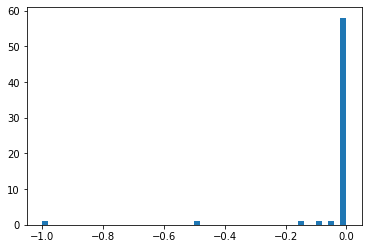

In [0]:
diff_plot = [i for i in difference.values()]
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

fig, axs = plt.subplots(1, 1)
axs.hist(diff_plot, bins=50)


In [0]:
import numpy as np

test_brand_dict_true = {}
test_brand_dict = {}

for review in TEST_DATA:
  test_ents_true = [review[0][start:end] for (start, end, label) in review[1]['entities']]
  doc = model(review[0])
  test_ents = [ent.text for ent in doc.ents]

  for entity in masked_entities:
    if entity in test_ents_true:
      if entity in test_ents:
        if entity in test_brand_dict.keys():
          test_brand_dict_true[entity] += 1
          test_brand_dict[entity] +=1
        else: test_brand_dict_true[entity] = 0; test_brand_dict[entity]=0
      elif entity in test_brand_dict_true.keys(): test_brand_dict_true[entity]+=1
      else: test_brand_dict_true[entity] = 0

In [0]:
test_brand_dict

{'1': 5,
 '20': 2,
 '25': 1,
 '25%': 0,
 '3': 5,
 '30 minutes': 1,
 '4': 6,
 '5': 6,
 '7': 1,
 '8': 1,
 '80': 0,
 'a few minutes': 1,
 'a week': 4,
 'afternoon': 4,
 'appetizer': 3,
 'apple': 3,
 'avocado': 6,
 'beef': 3,
 'bite': 4,
 'board': 0,
 'bread': 5,
 'breakfast': 12,
 'buffalo': 0,
 'burger': 10,
 'burrito': 3,
 'caesar salad': 0,
 'center': 3,
 'charlotte': 0,
 'chilli': 0,
 'chipotle': 1,
 'coconut': 2,
 'comfort food': 0,
 'cookie': 4,
 'delicious': 20,
 'dessert': 11,
 'dish': 7,
 'fast food': 1,
 'filling': 4,
 'food': 75,
 'friday': 1,
 'game': 3,
 'green': 2,
 'hash': 0,
 'ice cream': 2,
 'joint': 0,
 'lamb': 1,
 'meal': 14,
 'milkshake': 0,
 'minutes': 0,
 'monday': 3,
 'mustard': 1,
 'night': 1,
 'pepperoni': 0,
 'pie': 1,
 'pork belly': 1,
 'potato': 0,
 'rib': 1,
 'salad': 11,
 'salsa': 3,
 'sashimi': 2,
 'sauce': 16,
 'serving': 3,
 'shoulder': 1,
 'side': 13,
 'soup': 6,
 'special': 6,
 'spice': 3,
 'steak': 4,
 'sweet': 15,
 'sweet potato': 1,
 'table': 15,
 'th

In [0]:
test_brand_dict_true

{'1': 6,
 '20': 2,
 '25': 1,
 '25%': 0,
 '3': 5,
 '30 minutes': 1,
 '4': 6,
 '5': 6,
 '7': 1,
 '8': 1,
 '80': 0,
 'a few minutes': 1,
 'a week': 4,
 'afternoon': 4,
 'appetizer': 3,
 'apple': 3,
 'avocado': 6,
 'beef': 3,
 'bite': 4,
 'board': 0,
 'bread': 6,
 'breakfast': 12,
 'buffalo': 0,
 'burger': 10,
 'burrito': 3,
 'caesar salad': 0,
 'center': 3,
 'charlotte': 0,
 'chilli': 0,
 'chipotle': 1,
 'coconut': 2,
 'comfort food': 0,
 'cookie': 4,
 'delicious': 20,
 'dessert': 11,
 'dish': 7,
 'fast food': 1,
 'filling': 4,
 'food': 77,
 'friday': 2,
 'game': 3,
 'green': 2,
 'hash': 0,
 'ice cream': 2,
 'joint': 0,
 'lamb': 1,
 'meal': 14,
 'milkshake': 0,
 'minutes': 0,
 'monday': 4,
 'mustard': 1,
 'night': 2,
 'pepperoni': 0,
 'pie': 2,
 'pork belly': 1,
 'potato': 0,
 'rib': 1,
 'salad': 14,
 'salsa': 3,
 'sashimi': 2,
 'sauce': 17,
 'serving': 3,
 'shoulder': 1,
 'side': 13,
 'soup': 6,
 'special': 6,
 'spice': 3,
 'steak': 4,
 'sweet': 17,
 'sweet potato': 1,
 'table': 15,
 'th

In [0]:
ratios = {}
for key in test_brand_dict.keys():
  if test_brand_dict_true[key]!=0:
    ratios[key] = test_brand_dict[key]/test_brand_dict_true[key]

In [0]:
ratios

{'1': 0.8333333333333334,
 '20': 1.0,
 '25': 1.0,
 '3': 1.0,
 '30 minutes': 1.0,
 '4': 1.0,
 '5': 1.0,
 '7': 1.0,
 '8': 1.0,
 'a few minutes': 1.0,
 'a week': 1.0,
 'afternoon': 1.0,
 'appetizer': 1.0,
 'apple': 1.0,
 'avocado': 1.0,
 'beef': 1.0,
 'bite': 1.0,
 'bread': 0.8333333333333334,
 'breakfast': 1.0,
 'burger': 1.0,
 'burrito': 1.0,
 'center': 1.0,
 'chipotle': 1.0,
 'coconut': 1.0,
 'cookie': 1.0,
 'delicious': 1.0,
 'dessert': 1.0,
 'dish': 1.0,
 'fast food': 1.0,
 'filling': 1.0,
 'food': 0.974025974025974,
 'friday': 0.5,
 'game': 1.0,
 'green': 1.0,
 'ice cream': 1.0,
 'lamb': 1.0,
 'meal': 1.0,
 'monday': 0.75,
 'mustard': 1.0,
 'night': 0.5,
 'pie': 0.5,
 'pork belly': 1.0,
 'rib': 1.0,
 'salad': 0.7857142857142857,
 'salsa': 1.0,
 'sashimi': 1.0,
 'sauce': 0.9411764705882353,
 'serving': 1.0,
 'shoulder': 1.0,
 'side': 1.0,
 'soup': 1.0,
 'special': 1.0,
 'spice': 1.0,
 'steak': 1.0,
 'sweet': 0.8823529411764706,
 'sweet potato': 1.0,
 'table': 1.0,
 'three': 1.0,
 'to

In [0]:
final_in_common = list(set(masked_entities) & set(test_unique_brands))

In [0]:
len(final_in_common)

80

In [0]:
np.setdiff1d(unique_brands,new_unique_brands)

array(['apple', 'apple pie', 'asparagus', 'avocado', 'bloody mary',
       'breakfast food', 'caesar salad', 'center', 'cheese dip',
       'cheeseburger', 'cheesecake', 'chilli', 'chipotle', 'chuck',
       'coleslaw', 'comfort food', 'congee', 'corn beef', 'course',
       'crab legs', 'cream', 'cut of meat', 'dip', 'dumplings',
       'fast food', 'fixings', 'frozen yogurt', 'fudge', 'fudge sauce',
       'gem', 'goat cheese', 'grass', 'grits', 'hash', 'honeydew',
       'horseradish', 'hot dog', 'hot pot', 'jam', 'jelly', 'jerk',
       'joint', 'kale', 'lime', 'olive', 'onion', 'orange', 'penne',
       'pie', 'pork belly', 'potato salad', 'pudding', 'pumpkin',
       'red meat', 'red wine', 'riesling', 'rose', 'sangria', 'sausage',
       'savory', 'sea bass', 'serving', 'short ribs', 'shoulder', 'slice',
       'snack', 'sour', 'sugar', 'sugar cookie', 'sweet potato', 'taro',
       'tongue', 'topping', 'vanilla', 'vegetable', 'vodka', 'wasabi',
       'white chocolate', 'wine s

In [0]:
np.setdiff1d(new_unique_brands,unique_brands)

array(['&', '0.50', '1', '10', '10 minutes', '10 years', '10+ years',
       '100', '100.00', '12', '14', '15', '15+ years', '17', '19 cents',
       '1:30 pm', '1:45 p.m.', '2', '20', '20 minutes', '200', '25',
       '25 minutes', '25%', '280', '3', '3 years', '3-$4', '30 minute',
       '30 minutes', '35th', '37', '3:04 pm', '3:30', '4', '45', '5',
       '5 minutes ago', '5.25', '50.00', '51 february 5, 2017', '6', '66',
       '69', '6:30 p.m.', '7', '7-20', '72', '8', '80', '9', '92',
       'a couple months', 'a couple years ago', 'a few days',
       'a few days ago', 'a few days later', 'a few hours',
       'a few minutes', 'a few times years ago', 'a few years ago',
       "a mid 80's", 'a minute', 'a month', 'a night',
       'a two hour period', 'a week', 'a year', 'about 10 minutes',
       'about 15 minutes', 'about 30 seconds', 'about 5', 'about 50',
       'about two years ago', 'afternoon', 'all morning', 'all night',
       'almost $4', 'an extra $5', 'another 5 minu